Compressing from 1632 to 50 dimensions!

Iteration 1: MSE = 547.8825, sigma^2 = 0.3357
Iteration 2: MSE = 311.1591, sigma^2 = 0.1907
Iteration 3: MSE = 289.5552, sigma^2 = 0.1774
Iteration 4: MSE = 283.0171, sigma^2 = 0.1734
Iteration 5: MSE = 280.2261, sigma^2 = 0.1717
Iteration 6: MSE = 278.7835, sigma^2 = 0.1708
Iteration 7: MSE = 277.9263, sigma^2 = 0.1703
Iteration 8: MSE = 277.3660, sigma^2 = 0.1700
Iteration 9: MSE = 276.9770, sigma^2 = 0.1697
Iteration 10: MSE = 276.6955, sigma^2 = 0.1695
Iteration 11: MSE = 276.4848, sigma^2 = 0.1694
Iteration 12: MSE = 276.3221, sigma^2 = 0.1693
Iteration 13: MSE = 276.1926, sigma^2 = 0.1692
Iteration 14: MSE = 276.0870, sigma^2 = 0.1692
Iteration 15: MSE = 275.9991, sigma^2 = 0.1691
Iteration 16: MSE = 275.9249, sigma^2 = 0.1691
Iteration 17: MSE = 275.8617, sigma^2 = 0.1690
Iteration 18: MSE = 275.8076, sigma^2 = 0.1690
Iteration 19: MSE = 275.7611, sigma^2 = 0.1690
Iteration 20: MSE = 275.7211, sigma^2 = 0.1689
Iteration 21: MSE = 275.6867

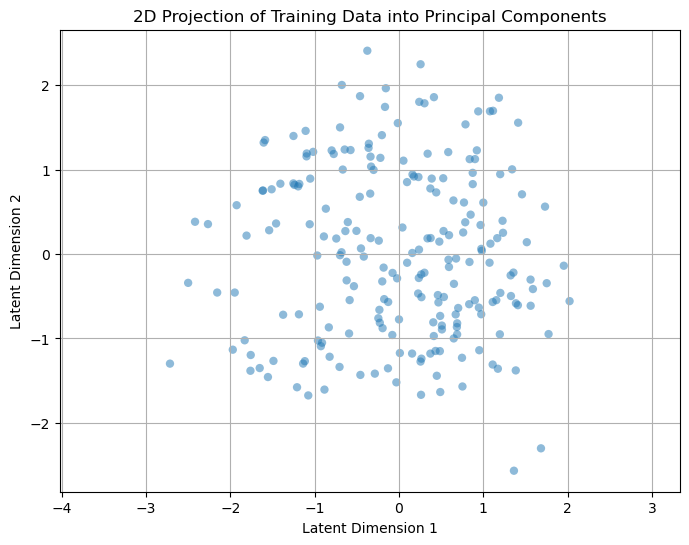

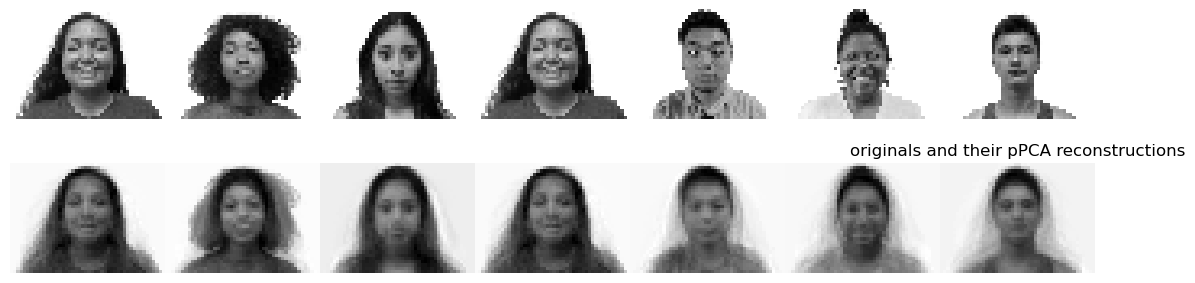

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
np.random.seed(42)
def robust_dot_product(A, B):
    """
    Perform a robust dot product that handles NaNs in either matrix.

    Parameters:
    - A: First matrix, could be pseudoinvZ or another part of the EM algorithm.
    - B: Second matrix, typically the data matrix X with potential NaNs.

    Returns:
    - C: Resultant matrix after performing dot product only on valid entries.
    """
    if A.shape[1] != B.shape[0]:
        raise ValueError("Matrices are not aligned for dot product!")

    # Initialize the output matrix with appropriate dimensions
    C = np.zeros((A.shape[0], B.shape[1]))
    
    for j in range(B.shape[1]):  # Iterate over columns of B
        valid_idx = ~np.isnan(B[:, j])  # Indices where B's column j is not NaN
        if np.any(valid_idx):
            C[:, j] = np.dot(A[:, valid_idx], B[valid_idx, j])
    
    return C
    
    
# Directory paths
input_filename = './X.npy'
truedims = (34,48)
Xorig = np.load(input_filename)
xMean = np.mean(Xorig, axis=0)  # Remember mean for later!
X = Xorig - xMean

N = X.shape[0]   # Number of rows in X, since each row is a data vector.
d = 50           # Low dimensionality, 
D = X.shape[1]   # Raw data's dimension.
assert D == np.prod(truedims), 'X does not seem to be the expected shape'
print(f'Compressing from {D} to {d} dimensions!\n')
noiseCov = 0.01 * np.eye(D)

zMu  = np.zeros(d)  
zCov = np.eye(d)
Z = np.random.multivariate_normal(zMu, zCov, N)
W = np.zeros((d,D))

# THIS IS THE EM ALGORITHM!
# TODO -----------------------------


num_iterations = 25
W = np.random.randn(d, D) * 0.01

# Initial noise variance (sigma^2)
sigma2 = 0.01

# Iterate EM steps
for it in range(num_iterations):
    # E-Step: Compute posterior for Z
    M = np.dot(W, W.T) + sigma2 * np.eye(d)  # Matrix M
    M_inv = np.linalg.inv(M)          # Inverse of M
    Z = np.dot(np.dot(M_inv, W), X.T).T  # Posterior for Z
    Z = (Z - np.mean(Z, axis=0)) / np.std(Z, axis=0) #Normalised


    # M-Step: Update W using Z and X
    W = np.dot(np.dot(X.T, Z), np.linalg.inv(np.dot(Z.T, Z) + sigma2 * np.eye(d))).T

    # Update sigma^2 (noise variance)
    X_prediction = np.dot(Z, W)
    reconstruction_error = X - X_prediction
    sigma2 = np.mean(reconstruction_error ** 2) / D  # Update sigma^2 based on reconstruction error

    # Compute Mean Squared Error (MSE)
    mse = np.mean((X - X_prediction) ** 2)
    
    # Print current iteration and MSE
    print(f"Iteration {it + 1}: MSE = {mse:.4f}, sigma^2 = {sigma2:.4f}")

# end of TODO ----------------------
print(W.shape)
print(N, D)
X_reconstructed = np.dot(Z, W) + xMean

# Plot the training set projected into principal components (latent variables Z)
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.5, edgecolors='none')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Projection of Training Data into Principal Components')
plt.axis('equal')  # Equal scaling of x and y axes
plt.grid(True)
plt.savefig('pPCA_latent_space.png')
plt.show()


#------------------------------------------------------------------------------
# Plot some originals and their pPCA reconstructions
ind1 = np.random.randint(1,N,7)
fig, axs = plt.subplots(2, 7, figsize=(14, 4))
for col in range(7):
    ax = axs[1, col]
    ax.imshow((X_reconstructed[ind1[col]]+ xMean).reshape(truedims), cmap='gray')
    ax.axis('off')
    ax = axs[0, col]
    ax.imshow((X[ind1[col]]+ xMean).reshape(truedims), cmap='gray')
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.title('originals and their pPCA reconstructions')
plt.savefig('pPCA_reconstructions.png')

#------------------------------------------------------------------------------
